# Lookup Table PSF

Make derive the wavelength-dependent PSF from a fixed-slit observation of a bright standard star.

Implemented in [PR #82](https://github.com/gbrammer/msaexp/pull/82).

In [1]:
import msaexp.spectrum
import glob
from scipy.stats import binned_statistic
from msaexp.resample_numba import pixel_integrated_gaussian_numba as PRF

import mastquery.jwst, mastquery.utils
import msaexp.spectrum
import msaexp.utils as msautils
import os
import glob

import numpy as np
from grizli.aws import db
from grizli import utils
import matplotlib.pyplot as plt

from msaexp.resample_numba import pixel_integrated_gaussian_numba as PRF
from scipy.stats import binned_statistic

import jwst.datamodels
from scipy.optimize import minimize, nnls

import scipy.optimize

Set ROOT_PATH=/usr/local/share/python/msaexp/docs/examples


## Read spectrum and pixel table

PRISM spectrum of P330E in the wide S1600 fixed slit from CAL-1538.

In [2]:
# Files added to https://github.com/gbrammer/msaexp/pull/82
ptab_file = 'https://github.com/user-attachments/files/17609875/fs_1538_prism-clear_p330e_s1600a1.pixtab.fits.gz'
spe_file = 'https://github.com/user-attachments/files/17609879/fs_1538_prism-clear_p330e_s1600a1.spec.fits.gz'

# Read them
sp = msaexp.spectrum.SpectrumSampler(spe_file)
ptab = utils.read_catalog(ptab_file, format='fits')

ptab['xint'] = np.interp(ptab['wave'], sp['wave'], np.linspace(0,1,len(sp['wave'])))
bin_wave = sp['wave']
wbins = msautils.array_to_bin_edges(bin_wave)

ptab = ptab[np.abs(ptab['yslit']) < 32]

print(ptab.colnames)

['sci', 'sky', 'var_total', 'var_rnoise', 'wave', 'dwave_dx', 'yslit', 'bar', 'profile', 'pathloss', 'exposure_index', 'exptime', 'xint']


In [3]:
# flat_sky = None

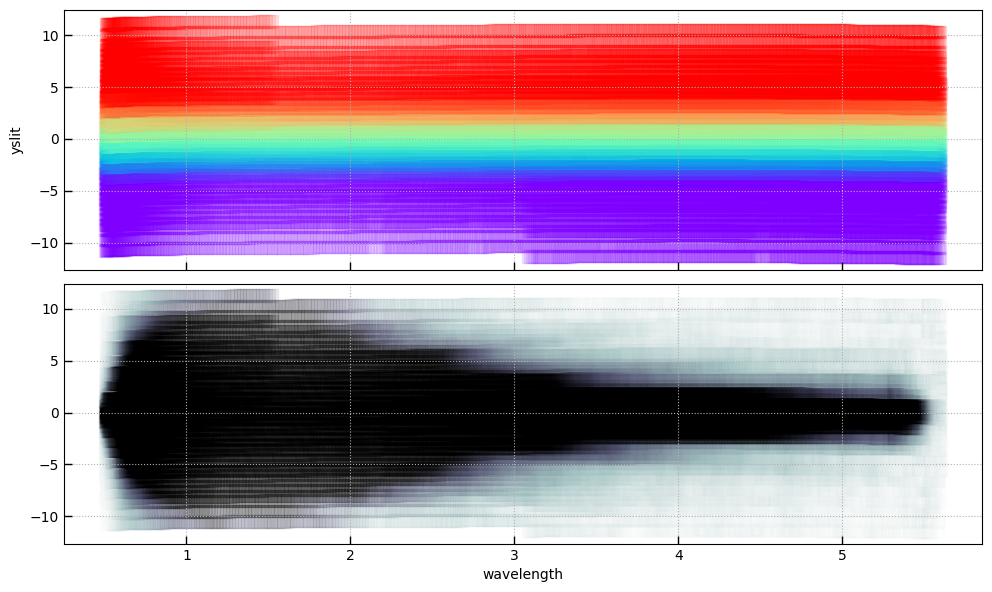

In [4]:
fig, axes = plt.subplots(2,1,figsize=(10,6), sharex=True, sharey=True)

s = 80
axes[0].scatter(ptab['wave'], ptab['yslit'], alpha=0.1, c=ptab['yslit'], vmin=-4, vmax=4, cmap='rainbow', marker='s', s=s)
axes[1].scatter(ptab['wave'], ptab['yslit'], alpha=0.1, c=ptab['sci'], cmap='bone_r', marker='s', s=s, vmin=-0.1, vmax=1000.6)

axes[0].set_ylabel('yslit')
axes[1].set_xlabel('wavelength')
for ax in axes:
    ax.grid()
    
fig.tight_layout(pad=1)

## Set profile components

Build a flexible profile as a sum of pixel-integrated Gaussians along the trace

In [5]:
trace_shift_coeffs = [0.]

dx = [0.1, 1]
ymax = ptab['yslit'].max() - 1
# ymax = np.minimum(ymax, np.abs(ptab['yslit'][ptab['bar'] > 0.09]).max())
dx = [0.1, 1.5*ymax/8]


steps = []
step = 0 #dx[0]
scl = 2
while step < ymax:
    steps.append(step)
    dx_i = np.interp(step, [0, ymax], dx)/scl
    step += dx_i

steps.append(step)
pcenters = np.append(-np.array(steps[1::][::-1]), np.array(steps))
pwidths = np.gradient(pcenters)*scl

undo_bar = 1.0

profs = []
for m, pw in zip(pcenters, pwidths):
    if trace_shift_coeffs is None:
        pi = PRF(ptab['yslit'].astype(float), m, pw, dx=1.)
    else:
        dy = np.polyval(trace_shift_coeffs, ptab['xint'])
        pi = PRF((ptab['yslit'] + dy).astype(float), m, pw, dx=1.)

    profs.append(pi)

profs = np.array(profs)

pw, pcenters

(1.8088787263116473,
 array([-10.51713581,  -9.61269644,  -8.78208708,  -8.01928091,
         -7.31874313,  -6.67539072,  -6.0845556 ,  -5.54195076,
         -5.04363911,  -4.58600498,  -4.16572783,  -3.77975819,
         -3.42529551,  -3.09976786,  -2.80081325,  -2.5262625 ,
         -2.27412352,  -2.04256682,  -1.82991224,  -1.63461681,
         -1.45526347,  -1.29055086,  -1.13928386,  -1.00036488,
         -0.87278595,  -0.75562138,  -0.64802103,  -0.54920417,
         -0.4584538 ,  -0.37511144,  -0.29857237,  -0.22828124,
         -0.16372802,  -0.10444433,  -0.05      ,   0.        ,
          0.05      ,   0.10444433,   0.16372802,   0.22828124,
          0.29857237,   0.37511144,   0.4584538 ,   0.54920417,
          0.64802103,   0.75562138,   0.87278595,   1.00036488,
          1.13928386,   1.29055086,   1.45526347,   1.63461681,
          1.82991224,   2.04256682,   2.27412352,   2.5262625 ,
          2.80081325,   3.09976786,   3.42529551,   3.77975819,
          4.1657278

## Fit profile in independent wavelength bins

In [6]:
spec_norm = np.ones_like(ptab['sci'])

In [7]:
# 32 wavelength steps across prism bandpass
wsteps = np.interp(np.linspace(0,1,32), np.linspace(0,1,len(sp['wave'])), sp['wave'])

coeffs = []

wht = 1./(spec_norm * np.sqrt(ptab['var_total']))
wht[~np.isfinite(wht)] = 0

for i, wi in enumerate(wsteps):
    sub = np.abs(ptab['wave'] - wi) <= np.gradient(wsteps)[i]/2
    # sub &= np.abs(ptab['yslit'] < 10)
    
    if sub.sum() == 0:
        coeffs.append(np.zeros(profs.shape[0]))
        continue

    
    c = scipy.optimize.nnls((profs[:,sub]*wht[sub]).T, (ptab['sci'] * undo_bar * wht)[sub])

    # print(wi)
    coeffs.append(c[0])

coeffs = np.array(coeffs)
cnorm = (coeffs.T / coeffs.sum(axis=1)).T
N = profs.shape[0]

cw = np.array([np.interp(ptab['wave'], wsteps, coeffs[:,i], left=coeffs[0,i], right=coeffs[-1,i]) for i in range(N)])
cwn = np.array([np.interp(ptab['wave'], wsteps, cnorm[:,i], left=cnorm[0,i], right=cnorm[-1,i]) for i in range(N)])
cprof = (cw*profs).sum(axis=0)
cprofn = (cwn*profs).sum(axis=0)


### Normalize by average spectrum


(-100000.0, 1500000.0)

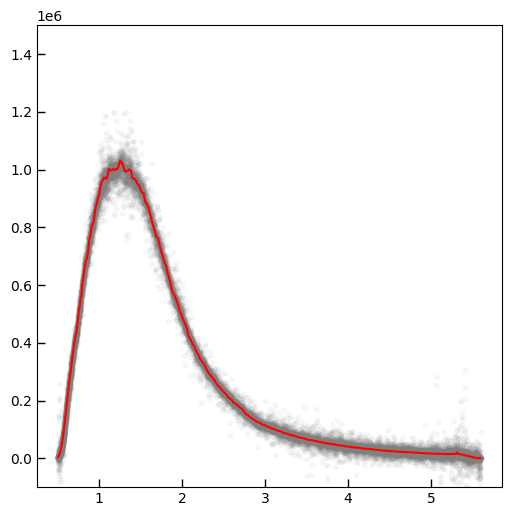

In [8]:
from scipy.stats import binned_statistic

normed = ptab['sci']/cprofn

plt.scatter(ptab['wave'], normed, alpha=0.05, color='0.5')

wht = cprofn**2/ptab['var_total']

bin_num = binned_statistic(ptab['wave'], normed*wht, bins=wbins, statistic='sum')
bin_den = binned_statistic(ptab['wave'], wht, bins=wbins, statistic='sum')
binned_spec = bin_num.statistic / bin_den.statistic

plt.plot(bin_wave, binned_spec, color='r')

spec_norm = np.interp(ptab['wave'], bin_wave, binned_spec)

plt.ylim(-0.1e6, 1.5e6)

### Fit again

In [9]:

coeffs = []

wht = 1./(1 * np.sqrt(ptab['var_total']))
wht[~np.isfinite(wht)] = 0

for i, wi in enumerate(wsteps):
    sub = np.abs(ptab['wave'] - wi) < np.gradient(wsteps)[i]/2
    # sub &= np.abs(ptab['yslit'] < 10)

    sub &= np.isfinite(spec_norm)
    
    if sub.sum() == 0:
        coeffs.append(np.zeros(profs.shape[0]))
        continue

    
    c = scipy.optimize.nnls((profs[:,sub]*wht[sub]).T, (ptab['sci'] / spec_norm * undo_bar * wht)[sub])

    # print(wi)
    coeffs.append(c[0])

coeffs = np.array(coeffs)
# Fill last bins
coeffs[-2:,:] = coeffs[-3,:]*1
coeffs[:1,:] = coeffs[1,:]*1

cnorm = (coeffs.T / coeffs.sum(axis=1)).T
N = profs.shape[0]

cw = np.array([np.interp(ptab['wave'], wsteps, coeffs[:,i], left=coeffs[0,i], right=coeffs[-1,i]) for i in range(N)])
cwn = np.array([np.interp(ptab['wave'], wsteps, cnorm[:,i], left=cnorm[0,i], right=cnorm[-1,i]) for i in range(N)])
cprof = (cw*profs).sum(axis=0)
cprofn = (cwn*profs).sum(axis=0)


(-5.0, 5.0)

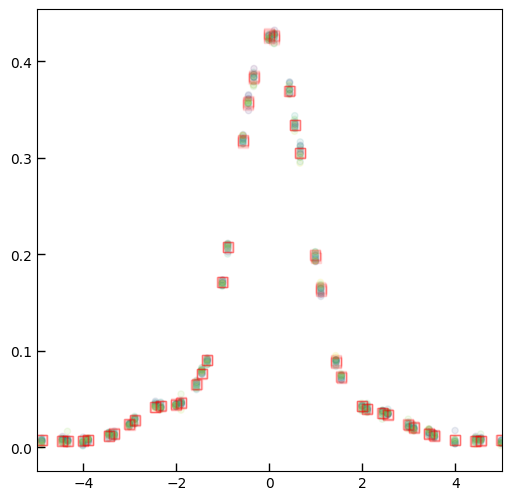

In [10]:
i = 24
wi = wsteps[i]
sub = np.abs(ptab['wave'] - wi) < np.gradient(wsteps)[i]/2
plt.scatter(ptab['yslit'][sub], (ptab['sci']/spec_norm)[sub], c=ptab['wave'][sub], alpha=0.1, s=80)
plt.scatter(ptab['yslit'][sub], (cprof)[sub], fc='None', ec='r', marker='s', alpha=0.05, s=50) 
plt.xlim(-5,5)

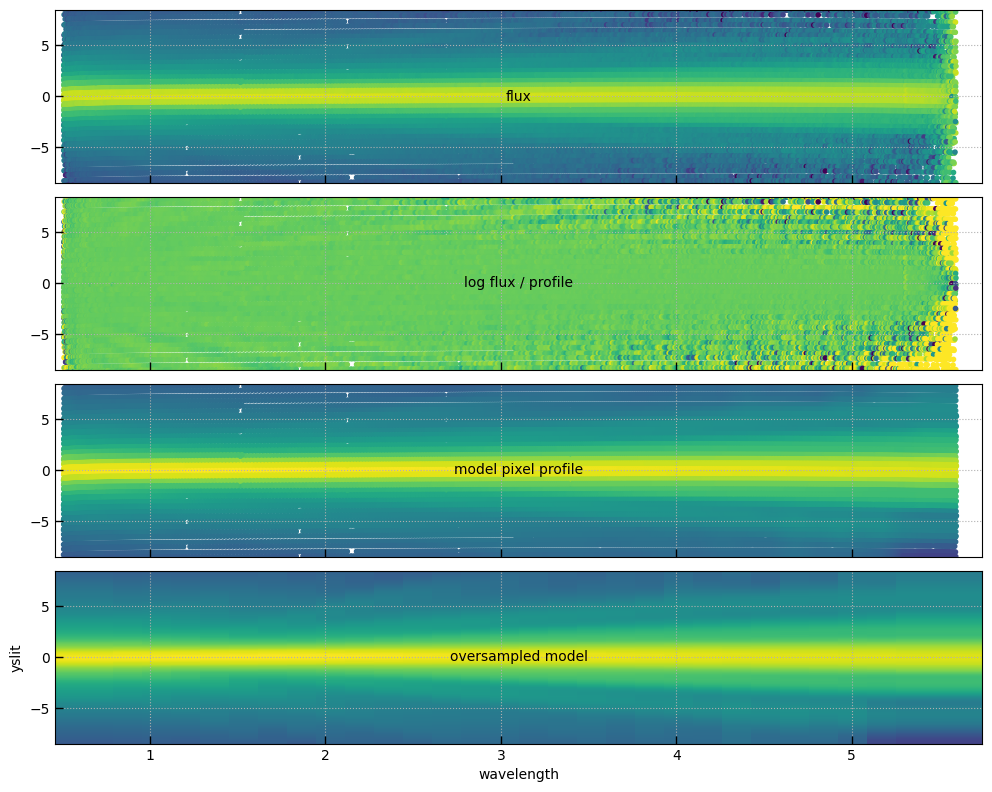

In [11]:
## Oversampled pixels

ystep = 32 # steps per pix
yarr = np.linspace(-8.5,8.5, int(8.5*2*ystep)+1)

xarr = wsteps

xgr, ygr = np.meshgrid(xarr, yarr)

xrange = (-1,1)

xi = np.interp(xgr.flatten(), sp['wave'], np.linspace(*xrange,len(sp['wave'])))
dy = np.polyval(trace_shift_coeffs, xi).flatten()

flat_profs = []
for mi, pwi in zip(pcenters, pwidths):
    pi = PRF(ygr.flatten() + dy, mi, pwi, dx=1.)
    flat_profs.append(pi)

flat_profs = np.array(flat_profs)

fcw = np.array([np.interp(xgr.flatten(), wsteps, coeffs[:,i], left=coeffs[0,i], right=coeffs[-1,i]) for i in range(N)])
fcwn = np.array([np.interp(xgr.flatten(), wsteps, cnorm[:,i], left=cnorm[0,i], right=cnorm[-1,i]) for i in range(N)])
fcprof = (fcw*flat_profs).sum(axis=0)
fcprofn = (fcwn*flat_profs).sum(axis=0)

fig, axes = plt.subplots(4,1,figsize=(10,8), sharex=True, sharey=True)

axes[0].scatter(ptab['wave'], ptab['yslit'], c=np.log10(ptab['sci']/spec_norm), vmin=-4, vmax=0.)

axes[1].scatter(ptab['wave'], ptab['yslit'], c=np.log10(ptab['sci']/spec_norm/cprofn), vmin=-1, vmax=0.3)

axes[2].scatter(ptab['wave'], ptab['yslit'], c=np.log10(cprofn), cmap='viridis', vmin=-4., vmax=-0.2)

axes[3].imshow(
    np.log10(fcprofn.reshape(xgr.shape)), vmin=-4., vmax=-0.2,
    aspect='auto',
    extent=(wsteps[0] - np.gradient(wsteps)[0], wsteps[-1] + np.gradient(wsteps)[-1], yarr[0], yarr[-1]),
    cmap='viridis',
)

for ax, label in zip(axes, ['flux', 'log flux / profile', 'model pixel profile', 'oversampled model']):
    ax.text(0.5, 0.5, label, color='k', ha='center', va='center', transform=ax.transAxes)
    
for ax in axes:
    ax.grid()

# ax.set_ylim(-5.5, 5.5)

ax.set_ylabel('yslit')
ax.set_xlabel('wavelength')

fig.tight_layout(pad=1)


If the model is a good representation of the profile, then the second panel from the top should look flat, which it mostly does with the exception of some minor diffraction spike residuals.

## Make PRF lookup table

Integrate the oversampled profile over the pixel width

In [12]:
x1 = ptab['xint']*(xrange[1] - xrange[0]) + xrange[0]
msk = (xi > x1.min()) & (xi < x1.max())

32it [00:00, 360.62it/s]


skip 0 0.5
skip 31 5.635442060363542


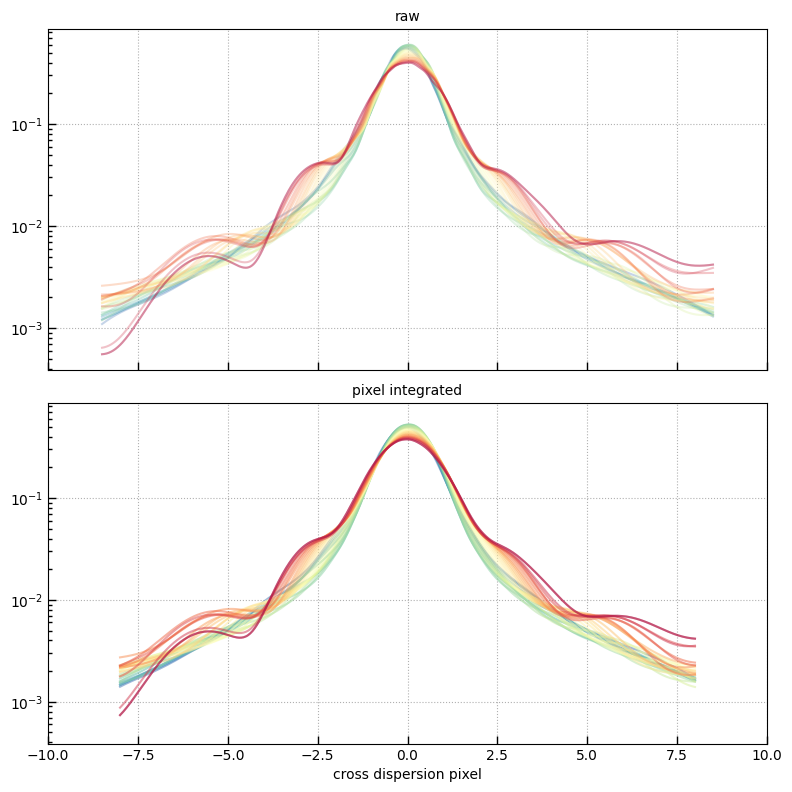

In [13]:
# Integrate over pixels for lookup table
from tqdm import tqdm

ystep2 = ystep//2

yc = yarr[ystep2:-ystep2]
yi = np.arange(len(yarr), dtype=int)[ystep//2:-ystep//2]
nyc = yc.size

pix_prof = np.zeros((nyc, xgr.shape[1]))

fig, axes = plt.subplots(2,1,figsize=(8,8), sharex=True, sharey=True)

slit_frac = wsteps*0.

for k, w in tqdm(enumerate(wsteps)):
    msk2d = msk.reshape(xgr.shape)
    if msk2d[:,k].sum() == 0:
        print('skip', k, wsteps[k])
        continue

    pj = fcprofn.reshape(xgr.shape)[:,k]    
    axes[0].plot(yarr, pj, color=plt.cm.Spectral_r((k+1)/len(wsteps)), alpha=0.3)
    
    # Integrate over pixels
    
    for i, j in enumerate(yi):
        sl = slice(j-ystep2, j+ystep2+1)
        pix_prof[i,k] = np.trapz(pj[sl], yarr[sl])
    
    axes[1].plot(yc, pix_prof[:,k], alpha=0.5, color=plt.cm.Spectral_r((k+1)/len(wsteps)))

    sk = np.abs(yarr) < 1
    slit_frac[k] = np.trapz(pj[sk], yarr[sk])
    
ax = axes[0]
ax.set_xlim(-6,6)
ax.set_xlim(-10,10)

axes[0].set_title('raw')
axes[1].set_title('pixel integrated')

ax.semilogy()

#ax.set_xlim(-5,5)
for ax in axes:
    ax.grid()

ax.set_xlabel('cross dispersion pixel')

fig.tight_layout(pad=1)

valid = pix_prof.sum(axis=0) > 0

pix_prof_wave = wsteps*1
pix_prof_wavei = np.arange(len(pix_prof_wave))

pix_prof_y = yc
pix_prof_yi = np.arange(len(pix_prof_y))

# pix_prof[:,0] = pix_prof[:,1]*1
# pix_prof[:,-1] = pix_prof[:,-2]*1

# slit_frac[0] = slit_frac[1]
# slit_frac[-1] = slit_frac[-2]

## Convolve with intrinsic Gaussian / Exponential profiles with a grid of widths

Precompute a grid of profiles where an intrinsic profile is convolved with the PSF and then integrated over pixels.

32it [00:04,  7.61it/s]


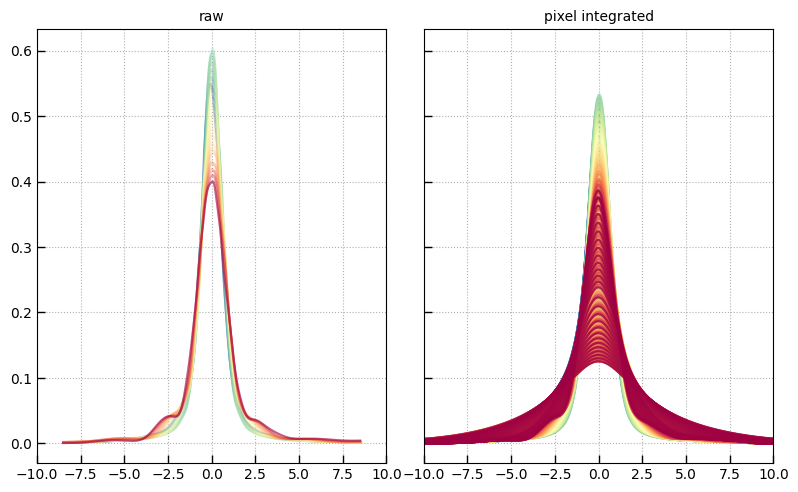

In [14]:
k = 10
pj = fcprofn.reshape(xgr.shape)[:,k]*1
# plt.plot(yarr, pj, color=plt.cm.Spectral_r((k+1)/len(wsteps)), alpha=0.5)

import scipy.ndimage as nd

dy = np.diff(yarr)[0]

xgau = np.arange(-12.5, 12.5, dy)
# xgau = yarr*1.

gsteps = np.append(0.0, np.logspace(-1, np.log10(2), 16))
# gsteps = np.append(0.0, np.logspace(np.log10(0.05), np.log10(2), 21))
# gsteps = np.linspace(0, 2, 21)

gsteps = np.linspace(0, 0.5, 11)
gsteps = np.append(np.arange(0, 0.7, 0.05), np.arange(0.7, 2.01, 0.1))


ystep2 = ystep//2

yc = xgau[ystep2:-ystep2]
yi = np.arange(len(xgau), dtype=int)[ystep//2:-ystep//2]
nyc = yc.size

pix_prof = np.zeros((nyc, len(wsteps), len(gsteps)))

fig, axes = plt.subplots(1,2,figsize=(8,5), sharex=True, sharey=True)

# source x offset goes from (-0.5, 0.5) corresponding to (-1, 1) pixels

slit_loss_steps = np.linspace(0,0.5,16)
slit_frac = np.zeros((len(wsteps), len(gsteps), len(slit_loss_steps)))

for k, w in tqdm(enumerate(wsteps)):
    # msk2d = msk.reshape(xgr.shape)
    # if msk2d[:,k].sum() == 0:
    #     print('skip', k, wsteps[k])
    #     continue

    pj = fcprofn.reshape(xgr.shape)[:,k]*1
    
    ycenter = (pj*yarr).sum() / pj.sum()
    # print(k, w, ycenter)

    # pj = np.interp(yarr + ycenter, yarr, pj)
    # ycenter = (pj*yarr).sum() / pj.sum()
    # print('xx', k, w, ycenter)

    axes[0].plot(yarr, pj, color=plt.cm.Spectral_r((k+1)/len(wsteps)), alpha=0.3)
    
    # Integrate over pixels
    for gi, gw in enumerate(gsteps):
        if gw == 0:
            conv = np.interp(xgau, yarr, pj, left=0, right=0)
        else:
            prof_type = 'gau'
            gau = 1/np.sqrt(2*np.pi*gw**2)*np.exp(-xgau**2/2/gw**2)
            # Exponential
            if 1:
                prof_type = 'exp'
                gau = 1./2 * np.log(2) / gw * np.exp(-np.abs(xgau) / gw * np.log(2))
            
            conv = nd.convolve1d(gau, pj/pj.sum())

        # print(gi, gw, np.trapz(gau, xgau), np.trapz(pj, yarr))
        # conv /= np.trapz(conv, xgau)
        
        for i, j in enumerate(yi):
            sl = slice(j-ystep2, j+ystep2+1)
            pix_prof[i,k,gi] = np.trapz(conv[sl], xgau[sl])
        
        axes[1].plot(yc, pix_prof[:,k,gi], alpha=0.5, color=plt.cm.Spectral_r((k+1)/len(wsteps)))
    
        for sli in range(len(slit_loss_steps)):
            
            sk = np.abs(xgau - slit_loss_steps[sli]*2) < 1
            slit_frac[k,gi,sli] = np.trapz(conv[sk], xgau[sk])
    
ax = axes[0]
ax.set_xlim(-6,6)
ax.set_xlim(-10,10)

axes[0].set_title('raw')
axes[1].set_title('pixel integrated')

#ax.set_xlim(-5,5)
for ax in axes:
    ax.grid()

fig.tight_layout(pad=1)

valid = pix_prof.sum(axis=0) > 0

pix_prof_wave = wsteps*1
pix_prof_wavei = np.arange(len(pix_prof_wave))

pix_prof_y = yc
pix_prof_yi = np.arange(len(pix_prof_y))

pix_prof_g = gsteps

# pix_prof[:,0,:] = pix_prof[:,1,:]*1
# pix_prof[:,-1,:] = pix_prof[:,-2,:]*1

# slit_frac[0,:] = slit_frac[1,:]
# slit_frac[-1,:] = slit_frac[-2,:]

## Path loss

The path loss is calibrated relative to a centered point source because that is how the throughput is defined.

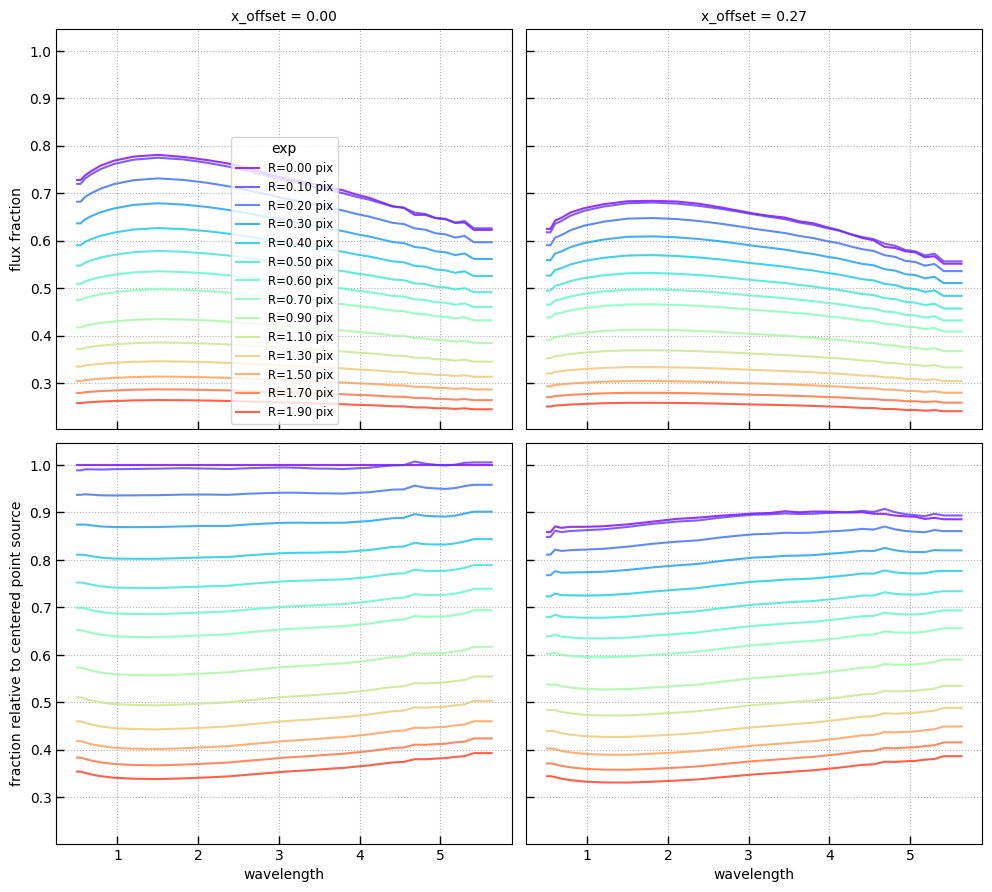

In [15]:
fig, axes = plt.subplots(2,2,figsize=(10,9), sharex=True, sharey=True)

for i, ioff in enumerate([0, 8]):
    ax = axes[0][i]
    ax2 = axes[1][i]
    for j in range(len(gsteps))[::2]:
        ax.plot(wsteps, slit_frac[:,j,ioff] / slit_frac[:,0,0]**0,
                alpha=0.8, color=plt.cm.rainbow(j/len(gsteps)),
                label = f'R={gsteps[j]:.2f} pix'
               )

        ax2.plot(wsteps, slit_frac[:,j,ioff] / slit_frac[:,0,0]**1,
                alpha=0.8, color=plt.cm.rainbow(j/len(gsteps)),
                label = f'R={gsteps[j]:.2f} pix'
               )

    ax.grid()
    ax2.grid()
    
    ax2.set_xlabel('wavelength')
    ax.set_title(f'x_offset = {slit_loss_steps[ioff]:.2f}')

leg = axes[0][0].legend(loc='lower center')
leg.set_title(prof_type)

axes[0][0].set_ylabel('flux fraction')
axes[1][0].set_ylabel('fraction relative to centered point source')

fig.tight_layout(pad=1)


### Write the lookup table file

In [16]:
import astropy.io.fits as pyfits
hdul = pyfits.HDUList([
    pyfits.PrimaryHDU(), 
    pyfits.ImageHDU(data=pix_prof, name='PROF'),
    pyfits.ImageHDU(data=pix_prof_y, name='YSLIT'),
    pyfits.ImageHDU(data=pix_prof_wave, name='WAVE'),
    pyfits.ImageHDU(data=pix_prof_g, name='SIGMA'),
    pyfits.ImageHDU(data=slit_loss_steps, name='LOSS_XOFFSET'),
    pyfits.ImageHDU(data=slit_frac, name='LOSS')
])

hdul['WAVE'].header['BUNIT'] = 'micron'
hdul.info()

hdul.writeto(f'nirspec_{prof_type}_psf_lookup.fits', overwrite=True, output_verify='fix')

Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  PROF          1 ImageHDU         9   (28, 32, 768)   float64   
  2  YSLIT         1 ImageHDU         7   (768,)   float64   
  3  WAVE          1 ImageHDU         8   (32,)   float64   
  4  SIGMA         1 ImageHDU         7   (28,)   float64   
  5  LOSS_XOFFSET    1 ImageHDU         7   (16,)   float64   
  6  LOSS          1 ImageHDU         9   (16, 28, 32)   float64   
